In [1]:
%load_ext autoreload
%autoreload 2

https://www.cl.cam.ac.uk/teaching/2021/LE49/probnn/3-3.pdf

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import precision_score, recall_score, roc_curve
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from constrained_metric_loss.min_precision_loss import MinPrecLoss, LearnableMinPrecLoss

# model

In [140]:
class LogReg(nn.Module):
    """Normal logistic regression with BCE loss"""
    def __init__(self, nfeat, model_param_init, loss, loss_arguments, trainable_loss_arguments=None):
        super().__init__()
        
        self.nfeat = nfeat
        self.beta = nn.Parameter(torch.from_numpy(model_param_init).float())
        assert nfeat + 1 == len(model_param_init), "Using the coefficient trick so need to add one extra parameter"
        
        self.loss = loss
        self.loss_arguments = loss_arguments
        self.trainable_loss_arguments = trainable_loss_arguments
        
        self.loss_func = self.loss(**self.loss_arguments)

            
        
    def forward(self, x, y):
        x = np.column_stack((x, np.ones([x.shape[0]])))
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y)
        
        
        self.f = x @ self.beta
        
        if self.trainable_loss_arguments:
            for i, p in enumerate(list(self.parameters())[1:]):
                p.data.clamp_(
                    self.trainable_loss_arguments[i][0], self.trainable_loss_arguments[i][1]
                )
                
                
                
        
        return self.loss_func(self.f, y.float())
    
    def predict_proba(self, xtest):
        
        if len(xtest.shape) == 1:
            xtest = xtest.reshape([1, self.nfeat])
        
        xtest = np.column_stack((xtest, np.ones([xtest.shape[0]])))
        xtest = torch.from_numpy(xtest).float()
        
        f = xtest @ self.beta
        return torch.sigmoid(f).detach().numpy().flatten()
    
    def fit(self, x, y, optimizer, n_batches=10_000, clipping=True):
        
        for i in range(n_batches):
            optimizer.zero_grad()
            loss = self.forward(x, y)
            loss.backward()
            optimizer.step()
                
            

#### set up model performance functions

In [134]:
def run_model(x, y, xtest, ytest, thresh, model_param_init, loss, loss_params, trainable_loss_arguments=None):
    model = LogReg(
        nfeat=x.shape[1], 
        model_param_init=model_param_init, 
        loss=loss, 
        loss_arguments=loss_params,
        trainable_loss_arguments=trainable_loss_arguments,
    )
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    model.fit(x, y, optimizer)
    
    

    phat = model.predict_proba(xtest)
    yhat = (phat >= thresh).astype(int)
    
    prec = precision_score(ytest, yhat)
    rec = recall_score(ytest, yhat)

    return prec, rec, model

# datasets

### Baisc data example

In [122]:
n = 10000

rng = np.random.default_rng(5)

x1 = rng.normal(0, 1, size=n)
x2 = rng.normal(3, 2.2, size=n)


beta0_true = -0.4
beta1_true = -5.3
beta2_true = 3.1

p = 1/(1+np.exp(-(beta0_true + beta1_true*x1 + beta2_true*x2)))

y_basic = rng.binomial(1, p, size=n)
x_basic = np.column_stack((x1, x2))

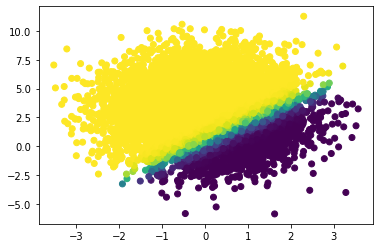

In [123]:
plt.scatter(x1, x2, c=p)

In [124]:
ntest = int(np.floor(n/10))

x1test = rng.normal(0, 1, size=ntest)
x2test = rng.normal(3, 2.2, size=ntest)

ptest = 1/(1+np.exp(-(beta0_true + beta1_true*x1test + beta2_true*x2test)))

xtest_basic = np.column_stack((x1test, x2test))

ytest_basic = rng.binomial(1, ptest, size=ntest)

In [125]:
param_init = np.zeros(x_basic.shape[1] + 1) # includes the intercept term

bce_prec, bce_recall, bce_model = run_model(
    x_basic, 
    y_basic, 
    xtest_basic, 
    ytest_basic, 
    0.5, 
    param_init, 
    loss = nn.BCEWithLogitsLoss, 
    loss_params = {}
)

bce_prec, bce_recall

(0.9803012746234068, 0.986013986013986)

In [129]:
param_init = np.zeros(x_basic.shape[1] + 1) # includes the intercept term

bce_prec, bce_recall, bce_model = run_model(
    x_basic, 
    y_basic, 
    xtest_basic, 
    ytest_basic, 
    0.5, 
    param_init, 
    loss = nn.BCEWithLogitsLoss, 
    loss_params = {"pos_weight": 0.3 * torch.ones(len(y_basic))}
)

bce_prec, bce_recall

(0.9880952380952381, 0.9673659673659674)

In [ ]:
sklearnlogreg = LogisticRegression()
sklearnlogreg = sklearnlogreg.fit(x_basic, y_basic)
param_init = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])

maxrecall_prec, maxrecall_recall, maxrecall_model = run_model(
    x_basic, 
    y_basic, 
    xtest_basic, 
    ytest_basic, 
    0.5, 
    param_init,
    loss = MinPrecLoss, 
    loss_params = {
        'min_prec':0.8, 
        'lmbda': 1e9, 
        'sigmoid_hyperparams': {'gamma': 7, 'delta': 0.035, 'eps': 0.75},
        # 'sigmoid_params': {'mtilde': 6.85,'btilde': -3.54, 'mhat': 6.85, 'bhat': 1.59}
    }
)


maxrecall_prec, maxrecall_recall

In [141]:

sklearnlogreg = LogisticRegression()
sklearnlogreg = sklearnlogreg.fit(x_basic, y_basic)
param_init = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])

maxrecall_prec, maxrecall_recall, maxrecall_model = run_model(
    x_basic, 
    y_basic, 
    xtest_basic, 
    ytest_basic, 
    0.5, 
    param_init,
    loss = LearnableMinPrecLoss, 
    loss_params = {
        'min_prec':0.8, 
        'lmbda': 1e9, 
        'lmbda2': 1e9, 
        'sigmoid_hyperparams': {
            'sigmoid_scale': nn.Parameter(torch.tensor(0.2)), 
            'mtilde': nn.Parameter(torch.tensor(6.8)), 
            'btilde': nn.Parameter(torch.tensor(-3.5)),
            'mhat': nn.Parameter(torch.tensor(6.8)),
            'bhat': nn.Parameter(torch.tensor(1.5))
        }
    },
    trainable_loss_arguments = [(0,10), (1, 50), (-10,-1), (1,50), (1, 10)]
)


maxrecall_prec, maxrecall_recall, list(maxrecall_model.parameters())

(0.9595505617977528,
 0.9953379953379954,
 [Parameter containing:
  tensor([-5.0187,  3.5720,  0.5401], requires_grad=True),
  Parameter containing:
  tensor(1.3514, requires_grad=True),
  Parameter containing:
  tensor(8.7476, requires_grad=True),
  Parameter containing:
  tensor(-1.4793, requires_grad=True),
  Parameter containing:
  tensor(7.3534, requires_grad=True),
  Parameter containing:
  tensor(1., requires_grad=True)])

### 1D dataset

In [12]:
from sklearn.datasets import make_classification

xsk, ysk = make_classification(
    n_samples=10000, 
    n_features=1, 
    n_informative=1, 
    n_redundant=0, 
    n_classes=2, 
    n_clusters_per_class=1, 
    class_sep=2.,
    random_state=6
)


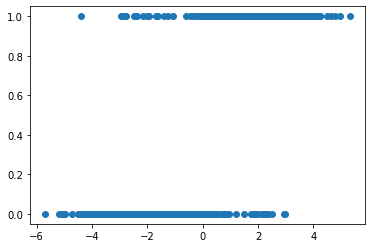

In [13]:
plt.scatter(xsk, ysk)

In [14]:
xsk_train = xsk[:9000]
ysk_train = ysk[:9000]

xsk_test = xsk[9000:]
ysk_test = ysk[9000:]

In [17]:

param_init = np.zeros(xsk_train.shape[1] + 1) # includes the intercept term

bce_prec, bce_recall, bce_model = run_model(
    xsk_train, 
    ysk_train, 
    xsk_test, 
    ysk_test, 
    0.5, 
    param_init, 
    loss = nn.BCEWithLogitsLoss, 
    loss_params = {}
)

bce_prec, bce_recall

(0.9842829076620825, 0.9842829076620825)

In [18]:
sklearnlogreg = LogisticRegression()
sklearnlogreg = sklearnlogreg.fit(xsk_train, ysk_train)
param_init = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])

maxrecall_prec, maxrecall_recall, maxrecall_model = run_model(
    xsk_train, 
    ysk_train, 
    xsk_test, 
    ysk_test, 
    0.5, 
    param_init,
    loss = MinPrecLoss, 
    loss_params = {
        'min_prec':0.8, 
        'lmbda': 1e4, 
        'sigmoid_hyperparams': {'gamma': 7, 'delta': 0.035, 'eps': 0.75},
        # 'sigmoid_params': {'mtilde': 6.85,'btilde': -3.54, 'mhat': 6.85, 'bhat': 1.59}
    }
)


maxrecall_prec, maxrecall_recall

(0.9387755102040817, 0.9941060903732809)

### moons dataset

In [19]:
from sklearn.datasets import make_moons

xmoons, ymoons = make_moons(n_samples = 10000, noise=0.1, random_state=7)

In [20]:
xmoons_train = xmoons[:9000]
ymoons_train = ymoons[:9000]

xmoons_test = xmoons[9000:]
ymoons_test = ymoons[9000:]

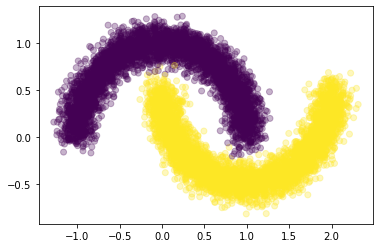

In [21]:
plt.scatter(xmoons_train[:,0], xmoons_train[:,1], c=ymoons_train, alpha=0.3)

In [22]:

param_init = np.zeros(xmoons_train.shape[1] + 1) # includes the intercept term

bce_prec, bce_recall, bce_model = run_model(
    xmoons_train,
    ymoons_train,
    xmoons_test,
    ymoons_test,
    0.5, 
    param_init, 
    loss = nn.BCEWithLogitsLoss, 
    loss_params = {}
)

bce_prec, bce_recall

(0.8668076109936576, 0.8631578947368421)

In [23]:
sklearnlogreg = LogisticRegression()
sklearnlogreg = sklearnlogreg.fit(xmoons_train, ymoons_train)
param_init = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])

maxrecall_prec, maxrecall_recall, maxrecall_model = run_model(
    xmoons_train,
    ymoons_train,
    xmoons_test,
    ymoons_test, 
    0.5, 
    param_init,
    loss = MinPrecLoss, 
    loss_params = {
        'min_prec':0.8, 
        'lmbda': 1e4, 
        'sigmoid_hyperparams': {'gamma': 7, 'delta': 0.035, 'eps': 0.75},
        # 'sigmoid_params': {'mtilde': 6.85,'btilde': -3.54, 'mhat': 6.85, 'bhat': 1.59}
    }
)


maxrecall_prec, maxrecall_recall

(0.8524590163934426, 0.8757894736842106)

In [144]:
sklearnlogreg = LogisticRegression()
sklearnlogreg = sklearnlogreg.fit(xmoons_train, ymoons_train)
param_init = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])

maxrecall_prec, maxrecall_recall, maxrecall_model = run_model(
    xmoons_train,
    ymoons_train,
    xmoons_test,
    ymoons_test, 
    0.5, 
    param_init,
    loss = LearnableMinPrecLoss, 
    loss_params = {
        'min_prec':0.8, 
        'lmbda': 1e8, 
        'lmbda2': 1e8, 
        'sigmoid_hyperparams': {
            'sigmoid_scale': nn.Parameter(torch.tensor(0.2)), 
            'mtilde': nn.Parameter(torch.tensor(6.8)), 
            'btilde': nn.Parameter(torch.tensor(-3.5)),
            'mhat': nn.Parameter(torch.tensor(6.8)),
            'bhat': nn.Parameter(torch.tensor(1.5))
        },
    },
    trainable_loss_arguments = [(0,10), (1, 50), (-10,-1), (1,50), (1, 10)]
)


maxrecall_prec, maxrecall_recall, list(maxrecall_model.parameters())

(0.9033018867924528,
 0.8063157894736842,
 [Parameter containing:
  tensor([ 0.8614, -6.2947,  0.5808], requires_grad=True),
  Parameter containing:
  tensor(0.0100, requires_grad=True),
  Parameter containing:
  tensor(7.5420, requires_grad=True),
  Parameter containing:
  tensor(-2.7551, requires_grad=True),
  Parameter containing:
  tensor(7.3347, requires_grad=True),
  Parameter containing:
  tensor(1., requires_grad=True)])

### dtatset from papaer

In [27]:
#https://github.com/tufts-ml/false-alarm-control/blob/main/toy_example_comparing_BCE_Hinge_and_Sigmoid.ipynb

from data import toydata

In [28]:
x_toy, y_toy, _, _, _, _ = toydata.create_toy_dataset()

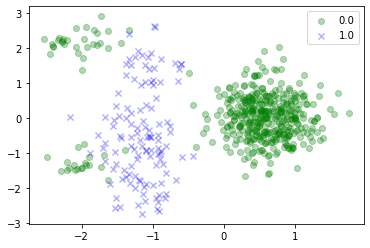

In [29]:
cdict = {0: 'green', 1: 'blue'}
mdict = {0:'o', 1:'x'}

fig, ax = plt.subplots()
for g in np.unique(y_toy):
    ix = np.where(y_toy == g)
    ax.scatter(x_toy[ix,0], x_toy[ix,1], c = cdict[g], marker=mdict[g], label = g, alpha=0.3)
ax.legend()

plt.show()

In [31]:
idx = np.array(range(y_toy.shape[0]))

rng.shuffle(idx)

In [32]:
xtrain_toy = x_toy[idx[:300]]
ytrain_toy = y_toy[idx[:300]]

xtest_toy = x_toy[idx[300:]]
ytest_toy = y_toy[idx[300:]]

In [33]:

param_init = np.zeros(xtrain_toy.shape[1] + 1) # includes the intercept term

bce_prec, bce_recall, bce_model = run_model(
    xtrain_toy,
    ytrain_toy,
    xtest_toy,
    ytest_toy,
    0.5, 
    param_init, 
    loss = nn.BCEWithLogitsLoss, 
    loss_params = {}
)

bce_prec, bce_recall

(0.6666666666666666, 0.6538461538461539)

In [34]:
sklearnlogreg = LogisticRegression()
sklearnlogreg = sklearnlogreg.fit(xtrain_toy, ytrain_toy)
param_init = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])

maxrecall_prec, maxrecall_recall, maxrecall_model = run_model(
    xtrain_toy,
    ytrain_toy,
    xtest_toy,
    ytest_toy, 
    0.5, 
    param_init,
    loss = MinPrecLoss, 
    loss_params = {
        'min_prec':0.8, 
        'lmbda': 1e4, 
        'sigmoid_hyperparams': {'gamma': 7, 'delta': 0.035, 'eps': 0.75},
        # 'sigmoid_params': {'mtilde': 6.85,'btilde': -3.54, 'mhat': 6.85, 'bhat': 1.59}
    }
)


maxrecall_prec, maxrecall_recall

(0.75, 0.6923076923076923)

In [149]:
sklearnlogreg = LogisticRegression()
sklearnlogreg = sklearnlogreg.fit(xtrain_toy, ytrain_toy)
param_init = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])

maxrecall_prec, maxrecall_recall, maxrecall_model = run_model(
    xtrain_toy,
    ytrain_toy,
    xtest_toy,
    ytest_toy, 
    0.5, 
    param_init,
    loss = LearnableMinPrecLoss, 
    loss_params = {
        'min_prec':0.8, 
        'lmbda': 1e8, 
        'lmbda2': 1e8, 
        'sigmoid_hyperparams': {
            'sigmoid_scale': nn.Parameter(torch.tensor(0.2)), 
            'mtilde': nn.Parameter(torch.tensor(6.8)), 
            'btilde': nn.Parameter(torch.tensor(-3.5)),
            'mhat': nn.Parameter(torch.tensor(6.8)),
            'bhat': nn.Parameter(torch.tensor(1.5))
        },
    },
    trainable_loss_arguments = [(-1,10), (0, 50), (-10,10), (0,50), (-10, 10)]
)


maxrecall_prec, maxrecall_recall, list(maxrecall_model.parameters())

(0.6451612903225806,
 0.38461538461538464,
 [Parameter containing:
  tensor([-0.9352, -1.7945, -2.6523], requires_grad=True),
  Parameter containing:
  tensor(-0.8161, requires_grad=True),
  Parameter containing:
  tensor(7.8115, requires_grad=True),
  Parameter containing:
  tensor(-2.4786, requires_grad=True),
  Parameter containing:
  tensor(7.7112, requires_grad=True),
  Parameter containing:
  tensor(0.5395, requires_grad=True)])

### diabites data

In [35]:
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

In [38]:
data_df = pd.read_csv('../data/diabetes2.csv')

df_train, df_test = train_test_split(data_df, test_size=0.3)

X_train = df_train.drop(columns='Outcome').values
y_train = df_train['Outcome'].values

X_test = df_test.drop(columns='Outcome').values
y_test = df_test['Outcome'].values

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [40]:
x_train_scaled = scaler.transform(X_train)
x_test_scaled = scaler.transform(X_test)

In [41]:
param_init = np.zeros(x_train_scaled.shape[1] + 1) # includes the intercept term

bce_prec, bce_recall, bce_model = run_model(
    x_train_scaled,
    y_train,
    x_test_scaled,
    y_test,
    0.5, 
    param_init, 
    loss = nn.BCEWithLogitsLoss, 
    loss_params = {}
)

bce_prec, bce_recall

(0.7, 0.5454545454545454)

In [42]:
sklearnlogreg = LogisticRegression()
sklearnlogreg = sklearnlogreg.fit(x_train_scaled, y_train)
param_init = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])

maxrecall_prec, maxrecall_recall, maxrecall_model = run_model(
    x_train_scaled,
    y_train,
    x_test_scaled,
    y_test,
    0.5, 
    param_init,
    loss = MinPrecLoss, 
    loss_params = {
        'min_prec':0.8, 
        'lmbda': 1e4, 
        'sigmoid_hyperparams': {'gamma': 7, 'delta': 0.035, 'eps': 0.75},
        # 'sigmoid_params': {'mtilde': 6.85,'btilde': -3.54, 'mhat': 6.85, 'bhat': 1.59}
    }
)


maxrecall_prec, maxrecall_recall

/Users/ee24pl/opt/miniconda3/envs/min_prec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0)